In [67]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

In [5]:

data_set = tf.keras.preprocessing.image_dataset_from_directory(
  'lfw_funneled',
  image_size=(250, 250),
  batch_size=50)

Found 13233 files belonging to 5749 classes.


In [10]:
class_names = data_set.class_names

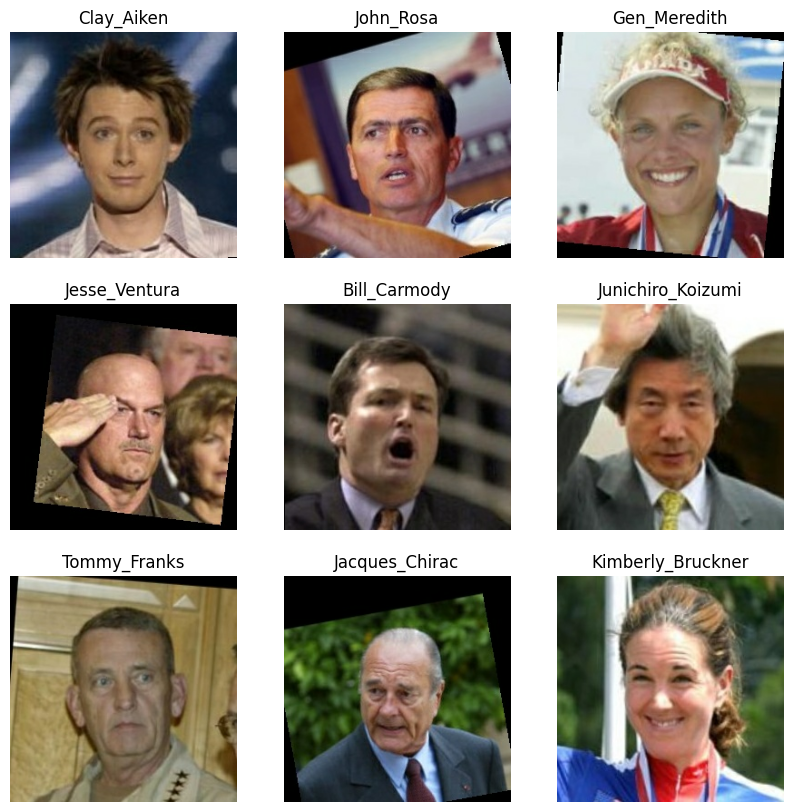

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [31]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = data_set.map(lambda x, y: (normalization_layer(x), y))

In [146]:
class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same"),
            layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"),
            layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"),
            layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"),  
            # layers.Reshape(shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

sample_instance = next(iter(normalized_ds))[0]

shape = sample_instance.shape
latent_dim = 10
autoencoder = Autoencoder(latent_dim, shape)

In [147]:
autoencoder.build(input_shape=shape)

In [124]:
shape

TensorShape([50, 250, 250, 3])

In [155]:
autoencoder.summary()

Model: "autoencoder_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_56 (Sequential)  (None, 63, 63, 32)        10144     
                                                                 
 sequential_57 (Sequential)  (None, 252, 252, 1)       18785     
                                                                 
Total params: 28929 (113.00 KB)
Trainable params: 28929 (113.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [158]:
autoencoder.compile(optimizer="adam", loss="mse")

In [159]:
autoencoder.fit(
  normalized_ds,
  validation_data=normalized_ds,
  epochs=3,
  batch_size=50,
)

Epoch 1/3
265/265 [==============================] - 675s 3s/step - loss: 10691821.0000 - val_loss: 10691827.0000
Epoch 2/3
265/265 [==============================] - 698s 3s/step - loss: 10691821.0000 - val_loss: 10691822.0000
Epoch 3/3
265/265 [==============================] - 734s 3s/step - loss: 10691820.0000 - val_loss: 10691821.0000
